# Load

In [1]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album
import math

from sklearn import model_selection
from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import joblib
import time
import pickle

class NeuralNetwork(nn.Module):
    """Neural network with LSTM layer and fully connected layer"""
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size=5,
                            num_layers=1,
                            batch_first=True
                            )
        self.fc1 = nn.Linear(in_features=5,
                             out_features=1)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

class CaImagesDataset(Dataset):
    """CA Images dataset."""
    # load the dataset
    def __init__(self, x, y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    # number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # get a sample from the dataset
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

# Segment image (TODO: replace with unet)
def get_blobs_adaptive(img, bound_size, min_brightness_const, min_area):
    im_gauss = cv2.GaussianBlur(img, (5, 5), 0) # "smoothing" the image with Gaussian Blur
    thresh = cv2.adaptiveThreshold(im_gauss,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,bound_size,(min_brightness_const))
    # Find contours
    cont, hierarchy = cv2.findContours(thresh, 
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE # only stores necessary points to define contour (avoids redundancy, saves memory)
                            )
    cont_filtered = []
    for con in cont: 
        area = cv2.contourArea(con) # calculate area, filter for contours above certain size
        if area>min_area: # chosen by trial/error
            cont_filtered.append(con)    
    
    # Draw + fill contours
    new_img = np.full_like(img, 0) # image has black background
    for c in cont_filtered:
        cv2.drawContours(new_img, # image to draw on
                        [c], # contours to draw
                        -1, # contouridx: since negative, all contours are drawn
                        255, # colour of contours: white
                        -1 # thickness: since negative, fill in the shape
                        )
    return new_img, cont_filtered
  
def scale_data_scaler(data, opt):
  """Scales data with MinMaxScaler or StandardScaler
  data: list of data to scale
  opt: "minmax" or "stand" 
  
  Returns scaler and scaled data"""
  if (opt == "minmax"):
    print("minmax")
    scaler = MinMaxScaler(feature_range=(0,1))
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  elif (opt == "stand"):
    print("stand")
    scaler = StandardScaler()
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  return scaler, norm_data

def scale_data(data, full:int):
  """Scales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns scaled data"""
  try:
     norm_data = [i/full for i in data]
  except:
      norm_data = data/full
  return norm_data

def unscale_data(data, full:int):
  """Unscales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns unscaled data"""
  try:
      norm_data = [i*full for i in data]
  except:
      norm_data = data*full
  return np.array(norm_data)

# get features and outcome variables
def get_features_and_outcome(num_prev, neuron_positions):
  """Returns dataframe with features and outcome variables
  num_prev: number of previous frames to use as features
  neuron_positions: list of neuron positions (x, y)
  
  Returns dataframe with features and outcome variables"""
  i = 0
  features_x = []
  features_y = []
  
  # scale data (x or y position)
  norm_neuron_positions_x = scale_data([x for (x, y) in neuron_positions], full=width)
  norm_neuron_positions_y = scale_data([y for (x, y) in neuron_positions], full=height)
    
  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    # each loop = feature for one "sample" (num_prev previous points)
    features_x.append(norm_neuron_positions_x[i:i+num_prev])
    features_y.append(norm_neuron_positions_y[i:i+num_prev])
    i+=1

  # make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': norm_neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': norm_neuron_positions_y[num_prev:], 'curr_frame': [i for i in range(num_prev, len(neuron_positions))]
          } 
  df = pd.DataFrame(dict)
  return df

# crop image to get image features
def crop_img(img, posx, posy, crop_size):
    return img[
                    posy-crop_size:posy+crop_size, 
                    posx-crop_size:posx+crop_size, 
                    :]
    
def get_features_and_outcome_w_visual(num_prev, neuron_positions, img_dir, max_height, max_width):
  """Returns dataframe with features and outcome variables
  num_prev: number of previous frames to use as features
  neuron_positions: list of neuron positions (x, y)
  
  Returns dataframe with features and outcome variables"""
  i = 0 # index of current frame
  features_x = []
  features_y = []
  features_x_colorhist = []
  features_x_mean= []
  features_x_meanstd = []
  PURPLE = (69, 6, 90)
  
  # scale data (x or y position)
  neuron_positions_x = [x for (x, y) in neuron_positions]
  neuron_positions_y = [y for (x, y) in neuron_positions]
    
  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    frame = i+num_prev
    
    # Get features from image
    act_x, act_y = neuron_positions[frame]
    img= cv2.imread(img_dir + str(frame) + ".png")
    img = cv2.copyMakeBorder(img, 0, max_height-img.shape[0], 0, max_width-img.shape[1], borderType=cv2.BORDER_CONSTANT, value=PURPLE) # Add padding
    cropped_img = crop_img(img, act_x, act_y, crop_size=12) # crop image around neuron
    
    # Get visual features from cropped image (neuron)
    features_x_meanstd.append(np.concatenate(cv2.meanStdDev(cropped_img)).flatten()) # mean and std of each channel
    features_x_mean.append(cv2.mean(cropped_img)[:3]) # mean of each channel
    features_x_colorhist.append(cv2.calcHist([cropped_img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]).flatten()) # color histogram
    
    # Get features from neuron positions
    features_x.append(neuron_positions_x[i:frame])
    features_y.append(neuron_positions_y[i:frame])
    
    i+=1

  # Make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': neuron_positions_y[num_prev:], 
          'channel_means': features_x_mean, 'channel_means_std': features_x_meanstd, 'color_hist': features_x_colorhist
          } 

  # Normalize features
  scaler = MinMaxScaler()
  df = pd.DataFrame(dict)
  df = pd.DataFrame(scaler.fit_transform(df),
                   columns=['prev_n_x', 'curr_x', 'prev_n_y', 'curr_y', 'channel_means', 'channel_means_std', 'color_hist'])
  
  df['curr_frame']= [j for j in range(num_prev, len(neuron_positions))]
  
  return df, scaler

# find centroids of segmented image & get scores
def find_centroids(segmented_img):
  """Returns list of centroids of segmented image
  segmented_img: segmented image (binary)
  """
  centroids = []
  cont, hierarchy = cv2.findContours(segmented_img, 
                          cv2.RETR_EXTERNAL, 
                          cv2.CHAIN_APPROX_SIMPLE)
  for c in cont:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))
  
  return centroids

def get_dist_score(x, y, x2, y2):
  """Returns distance score between two points
  x, y: coordinates of point 1
  x2, y2: coordinates of point 2"""
  return ((x2-x)**2)+((y2-y)**2)

def get_closest_cent(centroids:List, pred:Tuple):
    """ Returns the closest centroid to the predicted coordinates
    centroids: list of centroids
    pred: predicted coordinates"""
    min_score = 10**1000000
    predx, predy = pred
    cent_scores = {}
    coords = (0,0) # Closest to predicted coords

    for (pot_x, pot_y) in centroids:
        score = get_dist_score(predx, predy, pot_x, pot_y)
        cent_scores[(pot_x, pot_y)] = score
        if score <= min_score:
          min_score = score
          coords = (pot_x, pot_y)
    return coords, cent_scores

# get width, height coordinates to use for normalization
def get_norm_width_height(video_dir, position_dir, videos, imgs_dct, positions_dct):
  width, height = 0, 0 
  for video in videos:
      # Save imgs and positions in dictionary
      imgs_dct[video] = np.load(f"{video_dir}/{video}_crop.nd2.npy")
      positions_dct[video] = np.load(f"{position_dir}/AVA_{video}.mat.npy")
      print(f"Loaded {video}")
      h, w = imgs_dct[video].shape[2:]
      if h > height:
          height = h
      if w > width:
          width = w
  return width, height

def save_data(file, file_name):
   pickle.dump(file, open(f"{file_name}.pkl", "wb"))

def load_data(file_name):
  lst = pickle.load(open(f"{file_name}.pkl", "rb"))
  print(f"Loaded {file_name}")
  return lst




c:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run predictions

In [2]:
video='11408'

#SET CONSTANTS
video_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data\imgs"
position_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data\positions"
results_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\lstm"
videos = ['11408', '11409', "11410", '11411', '11413', '11414', '11415']
imgs_dct = {}
positions_dct={}
width, height = get_norm_width_height(video_dir, position_dir, videos, imgs_dct, positions_dct) # Get max height and width between all videos (for scaling)
print(f"Max width: {width} | Max height: {height}")
print(f"Finished loading images and positions: {len(imgs_dct)} images, {len(positions_dct)} positions")


Loaded 11408
Loaded 11409
Loaded 11410
Loaded 11411
Loaded 11413
Loaded 11414
Loaded 11415
Max width: 454 | Max height: 546
Finished loading images and positions: 7 images, 7 positions


In [7]:
model_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\models\lstm"
model = joblib.load(rf"{model_dir}\lstm_model_14.pkl")

In [ ]:

start_time = time.time()
video="11408"
ava = positions_dct[video]
n_input = 10
inputx = np.array(scale_data([x for (x, y) in ava][:n_input], width)).reshape((-1, 1)) # video 11408 has 2570 frames, these are the x positions of AVA for first 10 frames
inputy = np.array(scale_data([y for (x, y) in ava][:n_input], height)).reshape((-1, 1)) # y positions of AVA for first 10 frames

# Test metrics
num_correct = 0 # number of correct predictions
num_wrong = 0 # number of wrong predictions


# Dictionaries for plotting
centroid_lst = [] # key: frame, value: list of centroids
pred_lst = [] # key: frame, value: (predx, predy)
chosen_lst = [] # key: frame, value: selected (x, y) coordinates
streak_lst = [] # dictionary of streaks (key: frame, value: streak count)
act_lst = [] # key: frame, value: (actx, acty)
streak_count = 0
frame_reset_lst = [] # dictionary of frames to reset at (key: frame, value: predicted (x, y) coordinates)
f = open(file_name, "w")

# i=0 corresponds to frame 10
# in total, there are 2570 frames. We are predicting frames 10 to 2570, which means we use i=0 to i=2560
for i in range(0, len(ava)-n_input):
    frame = i+n_input # frame we are predicting
    print(f"frame {frame}")

    # features
    x_init = torch.from_numpy(np.float32(np.expand_dims(inputx[i:frame].reshape(-1, 1), 0))) # we take previous 10 frames as features
    y_init = torch.from_numpy(np.float32(np.expand_dims(inputy[i:frame].reshape(-1, 1), 0))) # this is scaled
    
    # predicted & actual coordinates
    predx = unscale_data(model(x_init).detach().numpy()[0][0], full=width) # this is unscaled
    predy = unscale_data(model2(y_init).detach().numpy()[0][0], full=height)
    pred_lst.append((predx, predy))

    actx, acty = ava[frame] # actual coordinates for this frame

    # Get list of centroids
    ground_truth_dir=rf'C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\{video}'
    mask = cv2.imread(f"{ground_truth_dir}/{frame}.png", cv2.IMREAD_GRAYSCALE)
    centroids = find_centroids(mask)  # list of potential centroids
    centroid_lst.append(centroids)

    # Find closest centroid
    coords, cent_scores = get_closest_cent(centroids, (predx, predy)) # this is unscaled
    act_coords, cent_scores_act= get_closest_cent(centroids, (actx, acty))
    f.write(f"Frame {i} \n")
    f.write(f"Pred: {predx}, {predy} \n")
    f.write(f"Actual: {actx}, {acty} \n")

    # prediction is correct if closest centroid to predicted coords is the same as closest centroid to actual coords
    if (coords == act_coords):
        print(f"Frame {frame} Correct \n")
        f.write(f"Frame {frame} Correct \n")
        inputx = np.append(inputx, scale_data(np.array(coords[0]).reshape(-1, 1)[0][0], width)) 
        inputy = np.append(inputy,  scale_data(np.array(coords[1]).reshape(-1, 1)[0][0], height))
        num_correct +=1
        streak_count+=1
    else:
        print(f"Frame {frame} False \n")
        f.write(f"Frame {frame} False \n")
        print(f"{act_coords[0]}, {act_coords[1]}")
        # if reset, use actual coordinates as input
        if reset:
        chosen_coords = act_coords
        # if not reset, use predicted coordinates as input (results if no human correction)
        else:
        chosen_coords = coords
        inputx = np.append(inputx, scale_data(np.array(chosen_coords[0]).reshape(-1, 1)[0][0], width)) 
        inputy = np.append(inputy, scale_data(np.array(chosen_coords[1]).reshape(-1, 1)[0][0], height))
        num_wrong +=1
        frame_reset_lst.append(frame)
        streak_lst.append(streak_count)
        streak_count=0
    

    chosen_lst.append((coords[0], coords[1]))
    act_lst.append((act_coords[0], act_coords[1]))

    for j in range(len(centroid_lst[i])):
        cent = centroid_lst[i][j]
        if cent == chosen_lst[i]:
        f.write(f" (Chosen) \n")
        if cent == act_lst[i]:
        f.write(f"(Actual) \n")
        f.write(f"Centroid: {cent} | Pred Score: {cent_scores[cent]} | Act Score: {cent_scores_act[cent]} \n")
    f.write("\n")
    print(f"Wrote frame {i}")

print(f"{num_correct}, {num_wrong}")
print("\n")
print(f"Time: {time.time() -start_time}")
f.write(f"{num_correct}, {num_wrong}")
f.close()
save_dir = rf'C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\{video}'
suffix = "_reset" if reset else ""
save_data(pred_lst, f"{save_dir}\pred_lst_{file_name}{suffix}")
save_data(chosen_lst, f"{save_dir}\chosen_lst_{file_name}{suffix}")
save_data(act_lst, f"{save_dir}\act_lst_{file_name}{suffix}")
save_data(centroid_lst, f"{save_dir}\centroid_lst_{file_name}{suffix}")
save_data(streak_lst, f"{save_dir}\streak_lst_{file_name}{suffix}")
save_data(frame_reset_lst, f"{save_dir}\frame_reset_lst_{file_name}{suffix}")
return pred_lst, chosen_lst, act_lst, centroid_lst, streak_lst, frame_reset_lst



# VIsualize

In [4]:
video='11408'
results_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408"
pred_lst = load_data(rf"{results_dir}\pred_lst_lstm_11408.txt")
chosen_lst = load_data(rf"{results_dir}\chosen_lst_lstm_11408.txt")
act_lst = load_data(rf"{results_dir}\act_lst_lstm_11408.txt")
centroid_lst = load_data(rf"{results_dir}\centroid_lst_lstm_11408.txt")
streak_lst = load_data(rf"{results_dir}\streak_lst_lstm_11408.txt")
frame_reset_lst = load_data(rf"{results_dir}\frame_reset_lst_lstm_11408.txt")


Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\pred_lst_lstm_11408.txt
Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\chosen_lst_lstm_11408.txt
Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\act_lst_lstm_11408.txt
Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\centroid_lst_lstm_11408.txt
Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\streak_lst_lstm_11408.txt
Loaded C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results_num\11408\frame_reset_lst_lstm_11408.txt


## Single Frame

Frame 1 | Pred: (array(148.32644176), array(55.61415339)) | Act: (162, 46) | Chosen: (146, 52)


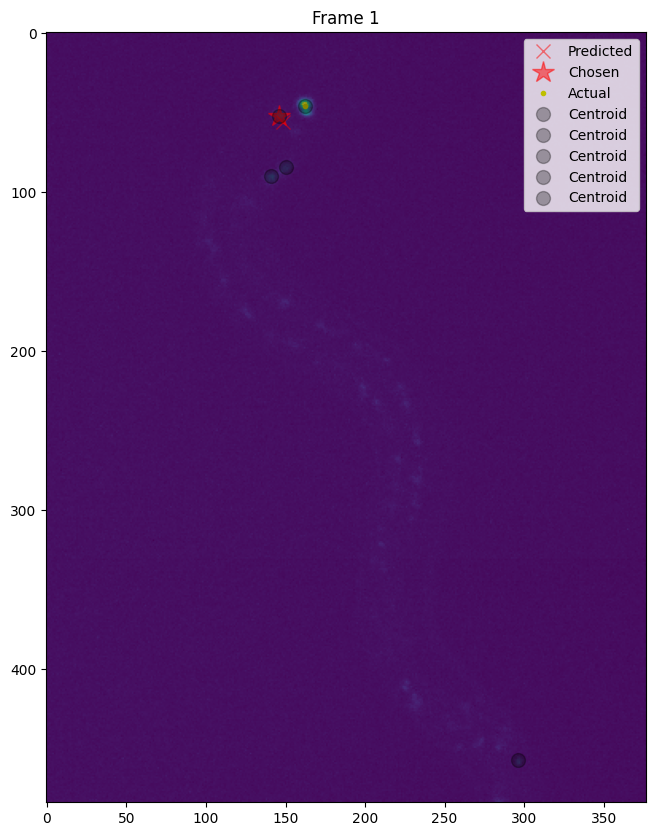

In [5]:
frame = 1
img = cv2.cvtColor(cv2.imread(f"C:\\Users\\hozhang\\Desktop\\CaTracking\\huayin_unet_lstm\\images\\original\\{video}\\{frame+10}.png"), cv2.COLOR_BGR2RGB)
pred_pt = pred_lst[frame]
act_pt = act_lst[frame]
chosen_pt = chosen_lst[frame]
print(f"Frame {frame} | Pred: {pred_pt} | Act: {act_pt} | Chosen: {chosen_pt}")

markersize = 10
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title(f"Frame {frame}")
plt.plot(pred_pt[0], pred_pt[1], 'rx', label="Predicted" , alpha=0.5, markersize=markersize)
plt.plot(chosen_pt[0], chosen_pt[1], 'r*', label="Chosen", alpha=0.5, markersize=markersize+6)
plt.plot(act_pt[0], act_pt[1], 'yo', label="Actual", alpha=1, markersize=markersize-7)
for cent in centroid_lst[frame]:
    plt.plot(cent[0], cent[1], 'ko', label="Centroid", alpha=0.3, markersize=markersize)
plt.legend()
plt.show()

In [6]:
# Solid dots, black/white background
def plot_all(frame, video, file_name):
    markersize = 9
    plt.figure(figsize=(10,10))
    img = cv2.imread(f"C:\\Users\\hozhang\\Desktop\\CaTracking\\huayin_unet_lstm\\images\\original\\{video}\\{frame+10}.png")
    pred_pt = pred_lst[frame]
    act_pt = act_lst[frame]
    chosen_pt = chosen_lst[frame]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.title(f"Frame {frame}")

    for cent in centroid_lst[frame]:
        plt.plot(cent[0], cent[1], 'wo', label="Centroid", alpha=1, markersize=markersize-7)

    plt.plot(pred_pt[0], pred_pt[1], 'ro', label="Predicted" , alpha=0.5, markersize=markersize)
    plt.plot(chosen_pt[0], chosen_pt[1], 'bo', label="Chosen", alpha=0.5, markersize=markersize)
    plt.plot(act_pt[0], act_pt[1], 'yo', label="Actual", alpha=1, markersize=markersize)
    plt.legend()
    plt.savefig(f"{file_name}.png")
    plt.close()

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42


KeyboardInterrupt: 

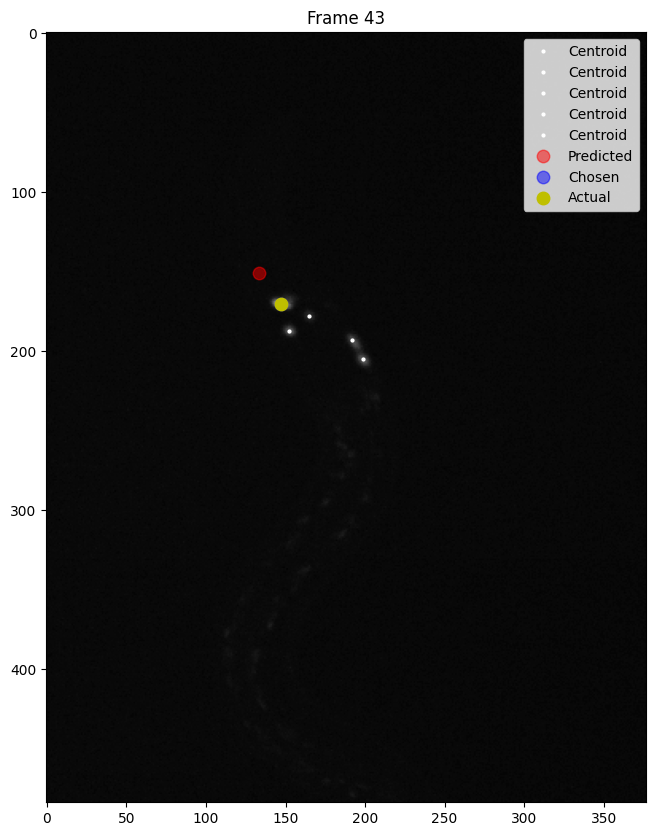

In [7]:
for i in range(len(centroid_lst)):
    plot_all(i, video, rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\{i}")
    print(f"Done {i}")

## Multi Frame: Path

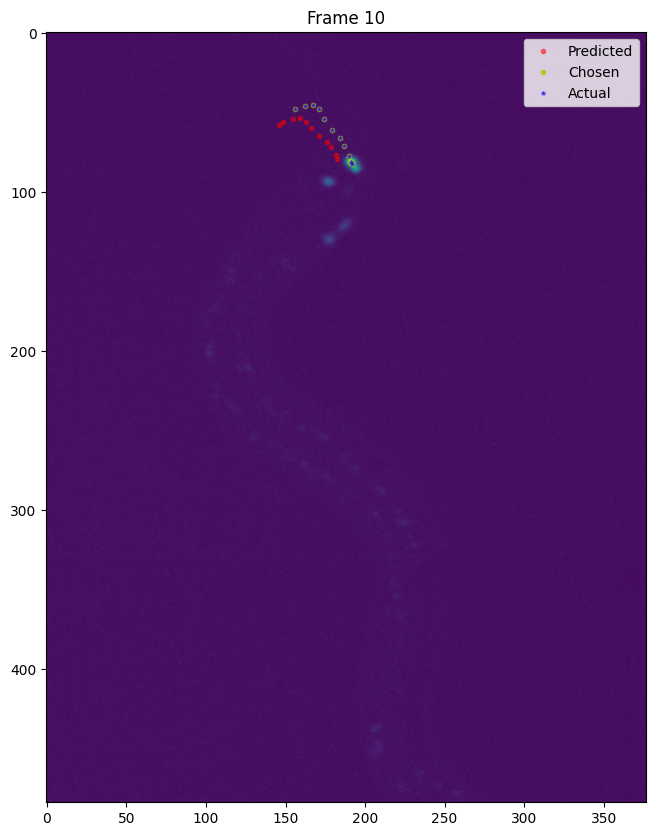

In [43]:
frame = 10
img = cv2.cvtColor(cv2.imread(f"C:\\Users\\hozhang\\Desktop\\CaTracking\\huayin_unet_lstm\\images\\original\\{video}\\{frame+10}.png"), cv2.COLOR_BGR2RGB)
pred_pts = pred_lst[:(frame+1)]
act_pts = act_lst[:(frame+1)]
chosen_pts = chosen_lst[:(frame+1)]

markersize = 3
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title(f"Frame {frame}")
plt.plot([x[0] for x in pred_pts], [x[1] for x in pred_pts], 'ro', label="Predicted" , alpha=0.5, markersize=markersize)
plt.plot([x[0] for x in chosen_pts], [x[1] for x in chosen_pts], 'yo', label="Chosen", alpha=0.8, markersize=markersize)
plt.plot([x[0] for x in act_pts], [x[1] for x in act_pts], 'b*', label="Actual", alpha=0.5, markersize=markersize)
plt.legend()
plt.show()